<h1>CNN model for dog and cat classification </h1>
<p> 1) A convolution neural network model built on pytorch. The model is parametrized, which is easy for optimization. </p>

<p> 2) Use Cifar10 as a test. The model reaches 92% accuracy on test data. The state of art accuracy is 97%. So there is still a lot to improve. The image data can be augumented by allowing crop and rotation. </p>



In [ ]:

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, n_modules, n_convols,  n_targets, in_channels, out_channels, kernel_size, stride, padding):
        super(CNN, self).__init__()

        blocks = []
        for i in range(n_modules):
            in_c = int((i>0)* (out_channels * (2**(i-1))) + (i==0)*in_channels)
            out_c = int(out_channels * (2**i))
            for j in range(n_convols):
                blocks.append(nn.Conv2d((j==0)*in_c + (j>0)*out_c, out_c, kernel_size, stride, padding))
                blocks.append(nn.BatchNorm2d(out_c))
                blocks.append(nn.ReLU())
            blocks.append(nn.Dropout2d(p=0.1))
            blocks.append(nn.MaxPool2d(2))

        self.module = nn.Sequential( *blocks )
        print(self.module)
        self.out = nn.Linear(out_c, n_targets)


    def forward(self, x):
        x = self.module(x)
        x = x.view(x.size(0), x.size(1), -1)
        x = x.mean(2)
        x = x.view(x.size(0),-1)
        output = self.out(x)
        output = F.log_softmax(output)
        return output


<p> The function that trains CNN model.  </p>
<p> train_loader, test_loader needs to be defined and passed in, which depends on specific data sets. The explanations of some tuning parameters are as follows: </p>
<p> N_EPOCH : number of train epoch </p>
<p> BATCH_SIZE  </p>
<p> LR : Initial learning rate </p>
<p> nnfile = 'cnn.pkl' : saved cnn model file for restart use </p>
<p> nnparamfile = 'cnn.pkl.params' : saved cnn parameter file for restart use </p>
<p> use_cuda = torch.cuda.is_available() : for large scale training, pytorch turns on gpu mode </p>

In [ ]:
'''
Factors that affect test accuracy:
1) Number of conv layer in each module.
2) Data augumentation. Implemented in cifar10.
3) Adaptive learning rate. 
4) Batch_size. 
5) Weigth_decay of SGD. 
6) Max pooling instead of fully connected layer.
7) Dropout layer.
8) Batch normalization.
9) Filter thickness.  
10) Adam vs SGD. 

To do: 
    write a dataloader for arbitrary data
    problem w. utils.progressbar when submit jobs
'''

import sys
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import cnn_models
#from utils import progress_bar

N_EPOCH = 300
BATCH_SIZE = 128 #150
LR = 10/100 #Initial learning rate
DOWNLOAD_MNIST = False
DOWNLOAD_CIFAR10 = False
nnfile = 'cnn.pkl' 
nnparamfile = 'cnn.pkl.params'
use_cuda = torch.cuda.is_available()
def train_and_save( net, train_loader, test_loader, lr, N_EPOCH, nnfile, nnparamfile):
    loss_function = nn.CrossEntropyLoss()
    log_train = open('Log_Train_'+str(LR) +'_'+ str(BATCH_SIZE)+'.txt','a')
    log_valid = open('Log_Valid_'+str(LR) +'_'+ str(BATCH_SIZE)+'.txt','a')
    epoch_id = 0
   
    for epoch in range(N_EPOCH):
        train_loss = 0 
        total = 0
        correct = 0
        if (epoch_id < 1.0/6 *N_EPOCH):
            lr = LR
        elif (epoch_id < 1.0/3*N_EPOCH):
            lr = LR/5.0
        elif (epoch_id < 2.0/3*N_EPOCH):
            lr = LR/10.0
        else:
            lr = 0.0028

        # train the current epoch
        # optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
        for batch_idx, (x,y) in enumerate(train_loader):
            if (use_cuda): 
                x, y = x.cuda(), y.cuda()

            b_x, b_y = Variable(x), Variable(y)
            prediction = net(b_x)
            loss = loss_function(prediction, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data[0]
            _, predicted = torch.max(prediction.data,1)
            total += b_y.size(0)
            correct += predicted.eq(b_y.data).cpu().sum()

        buff = 'epoch =' + str(epoch)+ ': train_loss: ' + str(train_loss/(batch_idx+1)) + ': train accuracy: ' + str(100.*correct/total)+'\n'
        log_train.write(str(100*correct/total))
        print(buff) 

        # test the current epoch
        net.eval() # switch net to 'test' mode
        test_loss = 0
        correct = 0
        total = 0
        loss_function = nn.CrossEntropyLoss()
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            outputs = net(inputs)
            loss = loss_function(outputs, targets)
            test_loss += loss.data[0]
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            
        buff = 'epoch =' + str(epoch)+ ': test accuracy: ' + str(100.*correct/total)+'\n'
        print(buff)
       
        net.train() # switch net to 'train' mode
        epoch_id += 1

#   end of training
    torch.save(net, nnfile+'.'+str(LR)+'.'+str(BATCH_SIZE))
    torch.save(net.state_dict(), nnparamfile+'.'+str(LR)+'.'+str(BATCH_SIZE))
    log_train.close()
    log_valid.close()
    return net



<p> The main function that defined and manipulate original data. </p>

In [ ]:
# train to reconginize CIFAR10 data
def main(argv):
    train_data = cifar10.CIFAR10(
        root = '../cifar10',
        train = True,
        download=DOWNLOAD_CIFAR10
    )
    train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE,
                                               shuffle = True, num_workers = 2)
    test_data = cifar10.CIFAR10(root='../cifar10/', train=False, download=False)
    test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = 100, shuffle=True, num_workers=2)

#   n_modules,   n_convols,  n_targets,
#   in_channels, out_channels,
#   kernel_size, stride, padding
    net = cnn_models.CNN(4,3,10,3,32,3,1,1)
    if use_cuda:
        net.cuda()
        net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        torch.backends.cudnn.enabled=True

    net = train_and_save( net, train_loader, test_loader, LR, N_EPOCH, nnfile, nnparamfile)

if __name__ == "__main__":
    main(sys.argv[1:])



<p> Process output accuracy for both test and train.  </p>
<p> It is found that test accuracy can reach up to 92% but cannot increase further by tuning parameters. There is still margin for the test accuracy to improve.  </p>

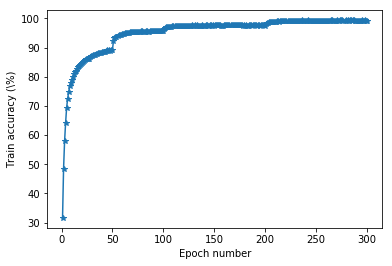

In [56]:
import matplotlib.pyplot as plt
import numpy as np

with open ("Log_Train_0.1_128.txt", "r") as myfile:
    data = myfile.read()

strs = data.split('.')
#print(strs)

list2 = []
i = 0
for number in strs:
    if number == '28\n':
        break
#    if i%2 == 0:
#        list2.append(strs[i] + '.' + strs[i+1][0:2])
#    else:
    list2.append(strs[i][-2:] + '.' + strs[i+1][0:2])
    i += 1
        
#print(list2)
#print(np.linspace(0,len(list2), len(list2)+1))  
plt.plot(np.linspace(1,len(list2),len(list2)), np.array(list2),'*-')
plt.ylabel('Train accuracy (\%)')
plt.xlabel('Epoch number')
plt.show()
#train_data = np.array(list2)


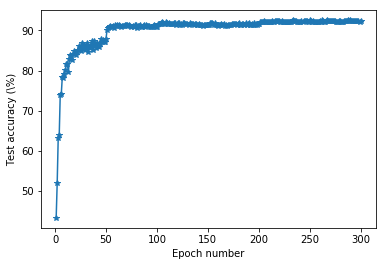

In [57]:
import matplotlib.pyplot as plt
import numpy as np

with open ("auto_10_128.pbs.o11777", "r") as myfile:
    data = myfile.read()

strs = data.split('\n')
#print(strs)

test_acc = []
for line in strs:
    s = line.split(':')
    if (len(s) == 3):
        test_acc.append(line.split(':')[2])

plt.plot(np.linspace(1,len(test_acc),len(test_acc)), np.array(test_acc),'*-')
plt.ylabel('Test accuracy (\%)')
plt.xlabel('Epoch number')
plt.show()


